In [8]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from hooks import ResidualHooks
from functional_space import (
    get_functional_basis_from_unembedding,
    project_functional,
)
import matplotlib.pyplot as plt

MODEL_NAME = "EleutherAI/pythia-70m-deduped"

In [2]:
def get_device():
    # Apple Silicon: MPS is usually fastest for this size
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("device:", device)

device: mps


In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if device.type == "mps" else torch.float32,
)
model.to(device)
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise

In [4]:
hooks = ResidualHooks(model, store_on_cpu=True)
hooks.add()

In [5]:
# --- Run one forward pass ---
text = "In the beginning, the universe was created. This has made a lot of people very angry"
enc = tokenizer(text, return_tensors="pt")
enc = {k: v.to(device) for k, v in enc.items()}

with torch.no_grad():
    out = model(**enc, output_hidden_states=True, use_cache=False)

In [6]:
# hidden_states is a tuple length (n_layers + 1):
# hidden_states[0] = embedding output (pre-first block)
# hidden_states[l+1] = output of block l (post residual add)
hidden_states = tuple(t.detach().to("cpu") for t in out.hidden_states)

print("n_layers:", len(model.gpt_neox.layers))
print("hidden_states:", len(hidden_states), "tensors")
print("example hidden shape:", hidden_states[-1].shape)  # (batch, seq, d_model)

print("captured attn layers:", len(hooks.attn_out))
print("captured mlp layers:", len(hooks.mlp_out))
print("attn[0] shape:", hooks.attn_out[0].shape)  # (batch, seq, d_model)
print("mlp[0] shape:", hooks.mlp_out[0].shape)

hooks.remove()

n_layers: 6
hidden_states: 7 tensors
example hidden shape: torch.Size([1, 18, 512])
captured attn layers: 6
captured mlp layers: 6
attn[0] shape: torch.Size([1, 18, 512])
mlp[0] shape: torch.Size([1, 18, 512])


In [7]:
U_f, svals2 = get_functional_basis_from_unembedding(model, Df=128, device="cpu")
print("U_f shape:", U_f.shape)
print("top eigenvalues (WU^T WU):", svals2[:5])

U_f shape: torch.Size([512, 128])
top eigenvalues (WU^T WU): tensor([4.5837e+05, 9.9161e+02, 4.6345e+02, 4.0979e+02, 2.9979e+02])


In [10]:
svals2.shape[0]

128

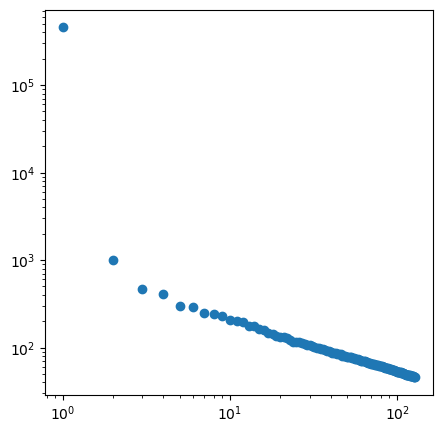

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(1 + torch.arange(svals2.shape[0]), svals2)
ax.set_yscale('log')
ax.set_xscale('log')